In [ ]:
pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import Bio.SeqIO as bio
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
import math

In [ ]:
seq = []
for i, record in enumerate(bio.parse("/content/PF00440_rp15.txt", "fasta")):
    seq.append(list(str(record.seq).upper()))

In [ ]:
df = np.array(seq)

In [ ]:
df[df == '-'] = np.nan

In [ ]:
df

array([['I', 'L', 'A', ..., 'E', 'A', 'L'],
       ['I', 'L', 'Q', ..., 'E', 'A', 'L'],
       ['L', 'I', 'T', ..., 'F', 'A', 'A'],
       ...,
       ['n', 'n', 'n', ..., 'n', 'n', 'n'],
       ['n', 'n', 'A', ..., 'N', 'H', 'n'],
       ['n', 'L', 'Q', ..., 'R', 'n', 'n']], dtype='<U1')

Here we drop columns where more than 50% empty values

In [ ]:
empty_col = []
for column in range(df.shape[1]):
  perc_nan = sum(df[:,column] == 'n') / len(df) * 100
  if perc_nan > 50:
    empty_col.append(column)

In [ ]:
df = np.delete(df,empty_col,1)

In [ ]:
df.shape

(12702, 46)

Here we can see distribution of empty values in columns

X - % of empty values in column

Y - number of columns with such % of empty values

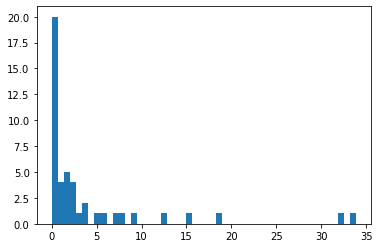

In [ ]:
plt.hist(pd.DataFrame(df).replace('n',np.NaN).isna().sum()/len(df)*100,bins = 50);

## Make labels

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
labels = []
for col in range(df.shape[1]):
  labels = set(list(np.unique(df[:,col])) + list(labels))

In [ ]:
labels = list(labels)
labels.remove('n')
# print something as example
labels[:3]

['C', 'L', 'E']

In [ ]:
# fit and apply the model for transformation 
le.fit(np.array(labels))
labels_transform = le.transform(np.array(labels))

In [ ]:
le.inverse_transform(labels_transform)

array(['C', 'L', 'E', 'D', 'X', 'Q', 'R', 'I', 'F', 'H', 'M', 'W', 'N',
       'P', 'Y', 'T', 'G', 'V', 'S', 'A', 'K'], dtype='<U1')

In [ ]:
labels_transform

array([ 1,  9,  3,  2, 19, 13, 14,  7,  4,  6, 10, 18, 11, 12, 20, 16,  5,
       17, 15,  0,  8])

In [ ]:
# let's apply the model to the data
df_labeled = df.copy()

for i,label in enumerate(le.classes_):
  df_labeled[df_labeled == label] = labels_transform[i]

In [ ]:
n = df.shape[1]
mut_matrix = np.zeros((n,n))

In [ ]:
df_labeled

array([['7', '6', '1', ..., '6', '2', '1'],
       ['7', '6', '1', ..., '6', '2', '1'],
       ['6', '7', '5', ..., '6', '1', '1'],
       ...,
       ['n', 'n', 'n', ..., '6', 'n', 'n'],
       ['n', 'n', '1', ..., '6', '1', '1'],
       ['n', '6', '1', ..., '1', '2', 'n']], dtype='<U1')

In [ ]:
def mutual_information(x_col, y_col):
  """
  Mutual information function
  Alexander and Dmitrii
  """
  summation = 0.0
  values_x = np.array(list(set(x_col)))
  values_y = np.array(list(set(y_col)))
  n = len(x_col)
  try:
    values_y.remove('n')
    values_x.remove('n')
  except:
    pass

  for x_i in values_x:
    for y_j in values_y:
      px = sum(np.where(x_col == x_i,1,0)) / n
      py = sum(np.where(y_col == y_j,1,0)) / n

      first = np.where(x_col==x_i,1,0)
      second = np.where(y_col==y_j,1,0)
      agreg = np.array([1 if first[i] * second[i] == 1 else 0 for i in range(len(first)) ])

      pxy = sum(agreg)/n

      if pxy > 0.0:
        summation += pxy * np.log( pxy  / (px*py) )
  return summation

In [ ]:
# Artem's function for mutural information

def prob_i(column, A, N):
    A = str(A)
    return sum(np.where(column == A,1,0))/N

def prob_joint_ij(column_i, column_j, A, B, N):
    A = str(A)
    B = str(B)
    c1 = np.where(column_i == A,1,0)
    c2 = np.where(column_j == B,1,0)
    n_ij = 0
    for i in range(c1.size):
      if c1[i] == c2[i] == 1:
        n_ij += 1
    return n_ij/N

def mutual_info(column_i, column_j, labels, N = None):
    N = len(column_i)
    mutual_info = 0
    for i in labels:
        for j in labels:
            p_i = prob_i(column_i, i, N)
            p_j = prob_i(column_j, j, N)
            R_ij = prob_joint_ij(column_i, column_j, i, j, N)
            if (R_ij > 0 and p_i > 0 and p_j > 0):
                mutual_info += R_ij*np.log( R_ij / (p_i * p_j))
    return mutual_info

def mutual_info_new(mi_matrix):
  new_mi_matrix = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      for k in range(n):
        s = mi_matrix[k, j] + mi_matrix[i, k]
      new_mi_matrix[i, j] = mi_matrix[i, j] - 1/n * s
  return new_mi_matrix

But in our case we will use function from sklearn because of normalization and speed (and quality)

In [ ]:
for i in range(n):
  for j in range(n):
    mut_matrix[i,j] = normalized_mutual_info_score(df_labeled[i],df_labeled[j])
    # mut_matrix[i,j] = adjusted_mutual_info_score(df_labeled[i],df_labeled[j])
    # mut_matrix[i,j] = mutual_information(df_labeled[i],df_labeled[j])

In [ ]:
pd.DataFrame(mut_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.000000,0.521777,0.522434,0.452128,0.423082,0.394151,0.427203,0.332400,0.396681,0.429910,...,0.418263,0.413743,0.332641,0.338015,0.459020,0.420629,0.339828,0.473906,0.472510,0.394296
1,0.521777,1.000000,0.390159,0.527101,0.438128,0.447708,0.385816,0.482598,0.387095,0.463587,...,0.445116,0.452606,0.274431,0.354701,0.307636,0.437934,0.292988,0.480660,0.351324,0.453154
2,0.522434,0.390159,1.000000,0.503551,0.349409,0.389867,0.566550,0.368508,0.357668,0.391951,...,0.329697,0.421834,0.383634,0.369315,0.407544,0.365975,0.366535,0.492726,0.576112,0.464840
3,0.452128,0.527101,0.503551,1.000000,0.368200,0.377029,0.602943,0.496202,0.486237,0.495547,...,0.420430,0.388433,0.271327,0.298269,0.311305,0.354370,0.579917,0.592851,0.539973,0.475696
4,0.423082,0.438128,0.349409,0.368200,1.000000,0.535904,0.346510,0.347809,0.440109,0.328375,...,0.478102,0.432919,0.467739,0.443853,0.471216,0.490055,0.349977,0.316542,0.359007,0.403469


In [ ]:
# Apply a filter to the data
result = mut_matrix > 0.5

In [ ]:
result

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False,  True, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True, False],
       [False, False, False, ...,  True, False,  True]])

In [ ]:
result = result.reshape(-1,1)

In [ ]:
final_file = []
for x in result:
  final_file += list(x.astype(int))

In [ ]:
final_file.insert(0, n)
print(final_file)

[46, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

In [ ]:
with open("map1.cmap", 'w') as f:
    for x in final_file:
      f.write(str(x)+'\n')